# 6. 주식_채권_현금_평균모멘텀_스코어_분산투자전략

In [1]:
import pandas as pd
import numpy as np

# Finance Library import
from Library import FinanceLibrary as fl

### csv 파일 읽어오기

In [2]:
import os
print (os.getcwd())

C:\DualMomentum\BackTesting


In [3]:
df_kodex = pd.read_csv("..\\Data\\KODEX200_daily_data.csv", encoding="utf-8")
df_bond10 = pd.read_csv("..\\Data\\KOSEF국고채10년_Daily_2011data.csv", encoding="utf-8")
df_bond3 = pd.read_csv("..\\Data\\KODEX국고채3년_Daily_2010data.csv", encoding="utf-8")

### Index는 datetime 형으로 변환하기

In [4]:
df_kodex.index = pd.to_datetime(df_kodex["Date"])
df_bond10.index = pd.to_datetime(df_bond10["Date"])
df_bond3.index = pd.to_datetime(df_bond3["Date"])

# 시작하는 날짜 지정하기, 채권 시작하는 날이 2011-12월이여서 주식도 시작날짜를 맞춤
df_kodex = df_kodex["2011-12":]
df_bond10 = df_bond10["2011-12":]
df_bond3 = df_bond3["2011-12":]

df_kodex = df_kodex["Close"]
df_kodex = df_kodex.resample("W-FRI")._upsample(None).interpolate()
#df_kodex = df_kodex.resample("BM").last()

df_bond10 = df_bond10["Close"]
df_bond10 = df_bond10.resample("W-FRI")._upsample(None).interpolate()
#df_bond10 = df_bond10.resample("BM").last()

df_bond3 = df_bond3["Close"]
df_bond3 = df_bond3.resample("W-FRI")._upsample(None).interpolate()
#df_bond3 = df_bond3.resample("BM").last()

KODEX = df_kodex/df_kodex[0]  #re-scale
BOND10 = df_bond10/df_bond10[0]  #re-scale
BOND3 = df_bond3/df_bond3[0]  #re-scale

In [5]:
# 일별 수익률
kodex_momentum_return = fl.MomentumDailyReturn(KODEX)  # 모멘텀 수익률은 내일 청산/금일 진입
bond10_momentum_return = fl.MomentumDailyReturn(BOND10)  # 모멘텀 수익률은 내일 청산/금일 진입
bond3_momentum_return = fl.MomentumDailyReturn(BOND3)  # 모멘텀 수익률은 내일 청산/금일 진입

In [6]:
# KODEX 평균모멘텀 스코어
kodex_average_score = pd.Series(fl.AverageMomentum(KODEX,12), index=KODEX.index, name="KODEX")
# BOND 평균모멘텀 스코어
bond10_average_score = pd.Series(fl.AverageMomentum(BOND10,12), index=BOND10.index, name="BOND10")

tri_ratio = pd.concat([kodex_average_score,bond10_average_score],axis=1).dropna()
# 투자 비중 = KODEX / ( KODEX 12개월 평균 모멘텀 + BOND10 12개월 평균 모멘텀 + 1(3개월 펀드=현금))
kodex_ratio = tri_ratio["KODEX"]/ (tri_ratio["KODEX"] + tri_ratio["BOND10"] + 1)
bond10_ratio = tri_ratio["BOND10"]/ (tri_ratio["KODEX"] + tri_ratio["BOND10"] + 1)
cash_ratio = 1 - (kodex_ratio + bond10_ratio)

tri_entry = (kodex_momentum_return * kodex_ratio) + (bond10_momentum_return * bond10_ratio)\
            + (bond3_momentum_return * cash_ratio)
TRI = np.cumprod(tri_entry)  # 누적 수익률

In [7]:
kodex = fl.Portfolio(KODEX,"KODEX")
bond10 = fl.Portfolio(BOND10,"BOND10")
cash = fl.Portfolio(BOND3,"CASH")
tri = fl.Portfolio(TRI,"TRI")

result = pd.concat([kodex,bond10,cash,tri],axis=1)
pd.DataFrame(result).T

,Initial Balnce,Final Balance,CAGR,Std,Max.Drawdown,Sharpe Ratio
KODEX,1.000000,1.266489,2.6597,0.1344,-21.0914,0.0443
BOND10,1.000000,1.372869,3.5839,0.1137,-8.2454,0.1611
CASH,1.000000,1.221828,2.2510,0.0647,-1.5830,0.3150
TRI,0.999803,1.321924,3.1518,0.0923,-4.3958,0.1538


### 그래프

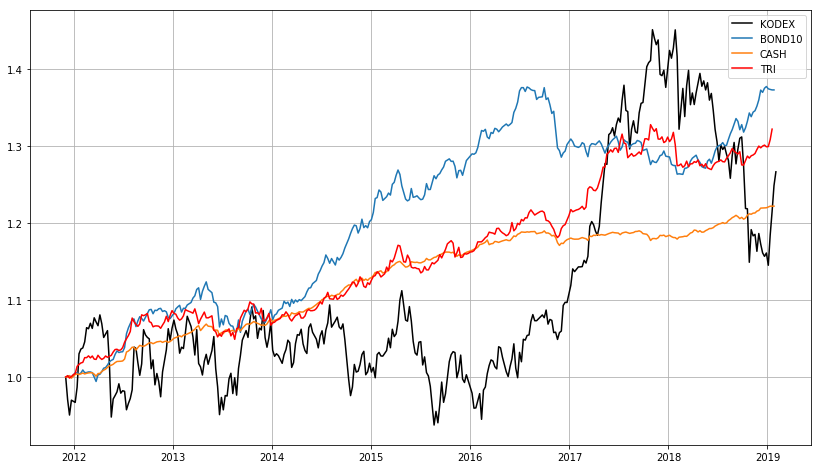

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(KODEX,color="Black",label="KODEX");
ax.plot(BOND10,label="BOND10");
ax.plot(BOND3,label="CASH");
ax.plot(TRI,color="Red",label="TRI");
ax.legend()
ax.grid()